# NLP Transformer: Training

In [1]:
!pip install Wikidata
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
import torch, random, requests, os, pickle
import numpy as np
from wikidata.client import Client
from datasets import load_dataset
from itertools import islice
from google.colab import userdata
from google.colab import drive

In [3]:
from transformers import set_seed

Setting seeds to try to make the training as much deterministic as possible.
This should help to compare results (for the instance accuracy of the validation test) of different trainings.

In [4]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [5]:
set_seed(42)

Wikipedia pages and Wikidata data need to be loaded from the web.
In order to speed up the training and the inference, we store (cache) the retrieved and the processed data in files.

In [6]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/Lost_in_Language_Recognition/'

def dump(file_name, result):
    file_path = BASE_PATH + file_name
    # remove dump files if present
    if os.path.exists(file_path):
        os.remove(file_path)
    with open(file_path, 'wb') as file:
        print("dumping", file_path)
        # noinspection PyTypeChecker
        pickle.dump(result, file)

def load(file_name):
    file_path = BASE_PATH + file_name
    with open(file_path, 'rb') as file:
        print("loading", file_path)
        # noinspection PyTypeChecker
        return pickle.load(file)

def file_exists(file_name):
    file_path = BASE_PATH + file_name
    return os.path.exists(file_path)

Mounted at /content/drive


In this section we build the singleton `NLPDataset`, that contains:
1. The original Hugging Face dataset
2. The Wikidata entities
3. The Wikipedia pages

In [7]:
def wikipedia_pages(sitelinks):
    result = []
    for site_key in sitelinks.keys():
        if site_key.endswith("wiki") and not site_key.startswith("commons"):
            lang = site_key.replace("wiki", "")
            result.append(lang)
    return result

def build_claims(claims):
    result = {}
    for prop_id, values in claims.items():
        result[prop_id] = len(values)
    return result

class Entity:
    def __init__(self, entity_id, dataset_item, wiki_data, wiki_text):
        self.entity_id = entity_id
        self.label = dataset_item['label']
        self.name = dataset_item['name']
        self.description = dataset_item['description']
        self.type = dataset_item['type']
        self.category = dataset_item['category']
        self.subcategory = dataset_item['subcategory']
        self.wiki_text = wiki_text
        # Languages
        self.labels = list(wiki_data.data.get("labels", {}).keys())
        self.descriptions = list(wiki_data.data.get("descriptions", {}).keys())
        self.aliases = list(wiki_data.data.get("aliases", {}).keys())
        self.wikipedia_pages = wikipedia_pages(wiki_data.data.get("sitelinks", {}))
        # Properties
        self.claims = build_claims(wiki_data.data.get("claims", {}))

    def __str__(self):
        return self.entity_id + ": " + self.label + " - " + self.name

API_URL = "https://en.wikipedia.org/w/api.php"

def extract_entity_id(url):
    return url.strip().split("/")[-1]

def get_wiki_text(en_wiki):
    if not en_wiki:
        return None
    title = en_wiki["title"]
    params = {
        "action": "query",
        "prop": "extracts",
        "explaintext": True,
        "titles": title,
        "format": "json",
        "redirects": 1
    }
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}
    res = requests.get(API_URL, params=params, headers=headers)
    json = res.json()
    page = next(iter(json["query"]["pages"].values()))
    # Keep the original text as it is.
    # The text will be processed in other methods,
    # such as processed_dataset#tokenize().
    return page.get("extract", "")

class EntityFactory:
    def __init__(self, client):
        self.client = client

    def create(self, item):
        entity_id = extract_entity_id(item['item'])
        try:
            wikidata = self.client.get(entity_id, load=True)
            sitelinks = wikidata.data.get("sitelinks", {})
            en_wiki = sitelinks.get("enwiki")
            return Entity(entity_id, item, wikidata, get_wiki_text(en_wiki))
        except Exception as e:
            print("Error loading id:", entity_id, e)
            return None

TRAINING_FILE_NAME = "training.bin"
VALIDATION_FILE_NAME = "validation.bin"

def create_set(dataset, factory, limit, file_name):
    # apply the limits
    if limit is None:
        limit = len(dataset)
    result = []
    for index, item in enumerate(islice(dataset, limit)):
        created = factory.create(item)
        if created is not None:
            result.append(created)
        if (index + 1) % 10 == 0:
            print("creating", file_name, index + 1, "/", limit)
    return result

class NLPDataset:
    def __init__(self, training_limit=None, validation_limit=None, force_reload=False):
        if not (file_exists(TRAINING_FILE_NAME)) or not (file_exists(VALIDATION_FILE_NAME)) or force_reload:
            # load the project dataset
            dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset', token=userdata.get('HF_TOKEN'))
            # a factory object is used to create our entities
            factory = EntityFactory(Client())

            self.training_set = create_set(dataset['train'], factory, training_limit, TRAINING_FILE_NAME)
            self.validation_set = create_set(dataset['validation'], factory, validation_limit, VALIDATION_FILE_NAME)
            dump(TRAINING_FILE_NAME, self.training_set)
            dump(VALIDATION_FILE_NAME, self.validation_set)
        else:
            # by default load the dataset from a local dump
            self.training_set = load(TRAINING_FILE_NAME)
            self.validation_set = load(VALIDATION_FILE_NAME)

    def __str__(self):
        return "training: " + str(len(self.training_set)) + ". validation: " + str(len(self.validation_set))

In [8]:
nlp_dataset = NLPDataset()

loading /content/drive/MyDrive/Lost_in_Language_Recognition/training.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/validation.bin


If the dump files `training.bin` and `validation.bin` are present, the instance is build from the dump.
And this is all we need to use the transformer. That is, usually with transformers we don't need to process the data.

In [9]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00


In [10]:
import csv
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, TrainerCallback
from matplotlib import pyplot as plt
from copy import deepcopy

In this case we will keep the description and the Wikipedia page text as they are, leaving the burden of taking text processing decisions to the tokenizer. The dataset here is enriched with the Wikipedia text and the labels are mapped to numbers:

In [11]:
def build_entity_dict():
    entity_dict = {}
    for entity in nlp_dataset.training_set:
        entity_dict[entity.entity_id] = entity
    for entity in nlp_dataset.validation_set:
        entity_dict[entity.entity_id] = entity
    return entity_dict

def label_to_number(label):
    if label == 'cultural agnostic':
        return 0
    if label == 'cultural representative':
        return 1
    if label == 'cultural exclusive':
        return 2
    raise ValueError('label not suppoerted: ' + label)

class WikiDataset:
    def __init__(self):
        entity_dict = build_entity_dict()
        dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset', token=userdata.get('HF_TOKEN'))
        # enriching the entities with the wiki pages
        def map_labels(sample):
            label = sample["label"]
            sample["label"] = label_to_number(label)
            wiki_id = extract_entity_id(sample["item"])
            if wiki_id is not None and wiki_id in entity_dict:
                wiki_text = entity_dict[wiki_id].wiki_text
                sample["wiki_text"] = wiki_text if type(wiki_text) == str else ""
            else:
                sample["wiki_text"] = ""
            return sample
        self.dataset = dataset.map(map_labels)

    def tokenize(self, tokenizer):
        def tokenize_function(items):
            return tokenizer(items["description"], items["wiki_text"], padding=True, truncation=True)
        return self.dataset.map(tokenize_function, batched=True)

Hugging Faces supports a lot of different encoders, we tried some of those.

In [12]:
LMs = {
    "bigbird": {
        "model_name": "google/bigbird-roberta-base",
        "max_length": 4096,
        "epochs": 4,
        "batch_size": 4
    },
    "distilbert": {
        "model_name": "distilbert-base-uncased",
        "max_length": 512,
        "epochs": 1,
        "batch_size": 32
    },
    "roberta_base": {
        "model_name": "roberta-base",
        "max_length": 512,
        "epochs": 5,
        "batch_size": 32
    },
    "roberta_large": {
        "model_name": "roberta-large",
        "max_length": 512,
        "epochs": 7,
        "batch_size": 32
    },
    "xlm_base": {
        "model_name": "xlm-roberta-base",
        "max_length": 512,
        "epochs": 7,
        "batch_size": 32
    },
    "xlm_large": {
        "model_name": "xlm-roberta-large",
        "max_length": 512,
        "epochs": 7,
        "batch_size": 32
    },
    "mdeberta_base": {
        "model_name": "microsoft/mdeberta-v3-base",
        "max_length": 512,
        "epochs": 7,
        "batch_size": 32
    },
    "mdeberta_large": {
        "model_name": "microsoft/mdeberta-v3-large",
        "max_length": 512,
        "epochs": 7,
        "batch_size": 32
    },
}
# Metrics
def compute_metrics(eval_pred):
    load_accuracy = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

class NLPHyperParams:
    def __init__(self):
        set_seed(42)
        key = "roberta_base"
        self.language_model_name = LMs[key]["model_name"]
        self.max_length = LMs[key]["max_length"]
        self.batch_size = LMs[key]["batch_size"]
        self.learning_rate = 1e-4
        self.weight_decay = 0.001
        self.epochs = LMs[key]["epochs"]
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print("device: ", self.device)

The Hugging Faces APIs are very high level hiding a lot of detail (and complexity) from the final user. Here we load the pretrained encorder (the encoder part of the transformer) and we apply the output embeddings to a feed forward network for classification.

In [13]:
class NLPEncoderModel:
    def __init__(self, params: NLPHyperParams):
        self.params = params
        ## Initialize the model
        self.model = AutoModelForSequenceClassification.from_pretrained(params.language_model_name, ignore_mismatched_sizes=True,
            output_attentions=False, output_hidden_states=False, num_labels=3) # number of the classes
        # Load the pretrained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(params.language_model_name)
        # Set the data collator
        # Function used to prepare the data before the training.
        # the data collator function used here apply a zero-padding on the elements in the batch
        # the padding is needed to have a "full" form of the batches
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def push(self, repo):
        self.model.push_to_hub(repo, token=userdata.get('HF_TOKEN'))

We introduces a custom callback to evaluate loss and accuracy of both the training and the validation sets. The idea here is to produce a result similar to the no-transformer part.

In [14]:
class CustomCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        self._trainer = trainer
        self.train_loss = []
        self.train_accuracy = []
        self.valid_loss = []
        self.valid_accuracy = []

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            train_evaluation = self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            self.train_loss.append(train_evaluation['train_loss'])
            self.train_accuracy.append(train_evaluation['train_accuracy'])
            valid_evaluation = self._trainer.evaluate(eval_dataset=self._trainer.eval_dataset, metric_key_prefix="valid")
            self.valid_loss.append(valid_evaluation['valid_loss'])
            self.valid_accuracy.append(valid_evaluation['valid_accuracy'])
            return control_copy

class NLPTrainer:
    def __init__(self, params: NLPHyperParams, model: NLPEncoderModel, train_dataset, eval_dataset):
        training_args = TrainingArguments(
            output_dir="training_dir",                      # output directory [Mandatory]
            num_train_epochs=params.epochs,                 # total number of training epochs
            per_device_train_batch_size=params.batch_size,  # batch size per device during training
            warmup_steps=500,                               # number of warmup steps for learning rate scheduler
            weight_decay=params.weight_decay,               # strength of weight decay
            save_strategy="no",
            eval_strategy="epoch",
            learning_rate=params.learning_rate,             # learning rate
            report_to="none",
            logging_dir="cultural_analysis_logs"           # use it later to get the training curves
        )
        self.trainer = Trainer(
            model=model.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=model.tokenizer,
            data_collator=model.data_collator,
            compute_metrics=compute_metrics,
        )
        self.callback = CustomCallback(self.trainer)
        self.trainer.add_callback(self.callback)

    def train_and_evaluate(self):
        self.trainer.train()
        return {
            "train_loss": self.callback.train_loss,
            "train_accuracy": self.callback.train_accuracy,
            "valid_loss": self.callback.valid_loss,
            "valid_accuracy": self.callback.valid_accuracy
        }

Putting all tougher we train (evaluate) and optionally publish the result.

device:  cuda


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label', 'wiki_text', 'input_ids', 'attention_mask'],
        num_rows: 6251
    })
    validation: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label', 'wiki_text', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
})


<ipython-input-14-b648d43cdc63>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.547339,0.796667
2,No log,0.569936,0.746667
3,0.571500,0.642456,0.760000
4,0.571500,0.829794,0.793333
5,0.571500,1.041862,0.776667


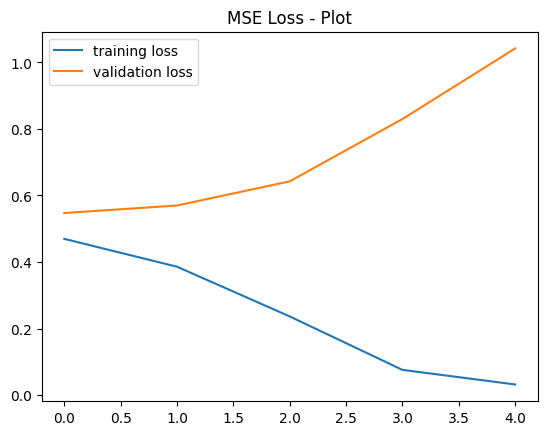

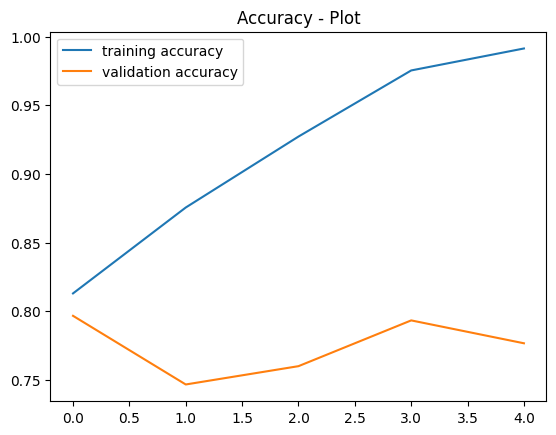

In [15]:
params = NLPHyperParams()
dataset = WikiDataset()
model = NLPEncoderModel(params)

print("Tokenize the dataset ...")
tokenized_datasets = dataset.tokenize(model.tokenizer)
print(tokenized_datasets)

train_ = tokenized_datasets["train"]
validation_ = tokenized_datasets["validation"]
trainer = NLPTrainer(params, model, train_, validation_)
history = trainer.train_and_evaluate()

plt.title("MSE Loss - Plot")
plt.plot(history["train_loss"], label="training loss")
plt.plot(history["valid_loss"], label="validation loss")
plt.legend()
plt.show()

plt.title("Accuracy - Plot")
plt.plot(history["train_accuracy"], label="training accuracy")
plt.plot(history["valid_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

# uncomment to push
# model.push("fax4ever/culturalitems-transformer")